Optimized parameters: [2.15309048 4.82341927 3.16849857]
Covariance of the parameters: [[ 0.01487794 -0.00320373  0.00759164]
 [-0.00320373  0.04124162 -0.02341883]
 [ 0.00759164 -0.02341883  0.03722455]]
Info dictionary: {'fvec': array([ 0.87412   ,  0.19128554,  0.47962103,  1.10967551,  0.9219173 ,
       -0.50165687,  0.46080754, -0.09119194, -0.06845117,  0.18708531,
        0.05240176,  0.70608876,  0.35803527,  0.03692729,  0.19662283,
        0.14017949,  0.71910686, -0.1316861 ,  0.12638264, -0.45808145,
       -1.30821486,  0.29463522,  0.39986024, -0.4033142 ,  1.10312248,
       -0.75806873, -0.00670408, -0.12139804,  0.74087532,  0.71200963,
        0.05823673,  0.17389743, -0.45437525, -0.99550796, -0.17300495,
        0.08588497,  0.6303165 ,  0.62451762, -0.16149768, -0.10948998,
       -0.47249569, -0.6475293 , -0.77943195,  1.06077336, -0.15737504,
       -0.10922436, -0.50402323,  0.52377547, -0.65928277,  0.05379023,
       -0.27534829,  0.37765838, -0.0599121 , -0.

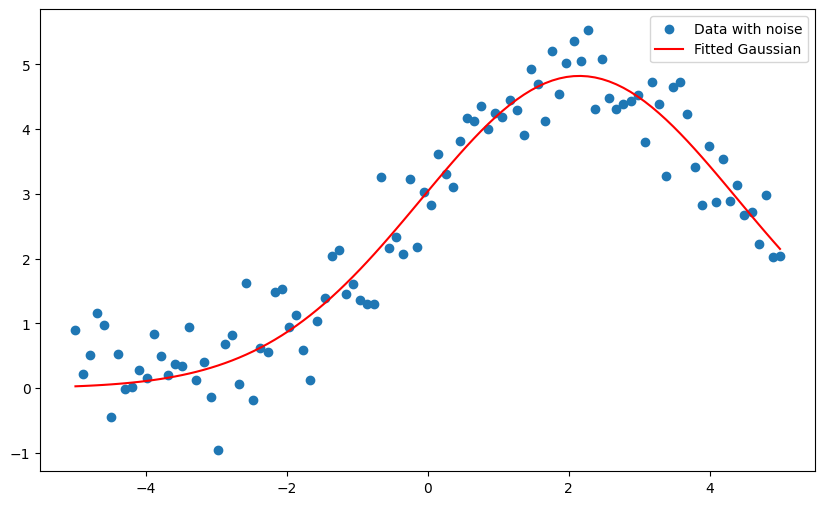

In [1]:
import numpy as np
from scipy.optimize import leastsq
import matplotlib.pyplot as plt

# 生成模拟数据
np.random.seed(0)  # 为了可重复性
x_data = np.linspace(-5, 5, 100)
true_params = [2, 5, 3]  # 真实参数：位置、高度、标准差
y_data = true_params[1] * np.exp(-((x_data - true_params[0]) / true_params[2]) ** 2) + np.random.normal(0, 0.5, x_data.shape)

# 定义模型函数
def my_func(params, x):
    return params[1] * np.exp(-((x - params[0]) / params[2]) ** 2)

# 定义残差函数
def residuals(params, x, y):
    return y - my_func(params, x)

# 初始参数猜测
initial_guess = [-1, 1, 1]

# 进行拟合
result = leastsq(residuals, initial_guess, args=(x_data, y_data), full_output=True)

# 打印结果
print("Optimized parameters:", result[0])
print("Covariance of the parameters:", result[1])
print("Info dictionary:", result[2])
print("Message:", result[3])
print("Exit status:", result[4])

# 绘制原始数据和拟合结果
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Data with noise')
plt.plot(x_data, my_func(result[0], x_data), 'r-', label='Fitted Gaussian')
plt.legend()
plt.show()

## leastsq提供的fjac并不是雅可比矩阵，而是矩阵分解出来的R矩阵。
leastsq库通过下面的方式来计算逆hessian矩阵result[1]

The inverse of the Hessian. `fjac` and `ipvt` are used to construct an
        estimate of the Hessian.

`cov_x 是逆海森矩阵的估计，要得到参数的协方差矩阵，需要将 cov_x 乘以残差的方差。`

In [2]:
from scipy.linalg import get_lapack_funcs

ipvt = result[2]["ipvt"]
fjac = result[2]["fjac"]
print(ipvt.shape, fjac.shape)

perm = ipvt - 1
n = len(perm)
r = np.triu(np.transpose(fjac)[:n, :])
inv_triu = get_lapack_funcs('trtri', (r,))
# inverse of permuted matrix is a permuation of matrix inverse
invR, trtri_info = inv_triu(r)  # default: upper, non-unit diag
invR[perm] = invR.copy()
cov_x = invR @ invR.T
cov_x

(3,) (3, 100)


array([[ 0.01487794, -0.00320373,  0.00759164],
       [-0.00320373,  0.04124162, -0.02341883],
       [ 0.00759164, -0.02341883,  0.03722455]])

## 通过完整的雅可比矩阵来计算逆hessian矩阵

公式如下：$ \text{Cov}(\boldsymbol{\beta}) = \sigma^2 \cdot (\mathbf{J}^\top \mathbf{J})^{-1} $

In [3]:
from scipy.optimize import leastsq
import numpy as np

# 定义残差函数
def residuals(params, x, y):
    return y - my_func(params, x)

# 定义雅可比矩阵计算的数值方法
def numerical_jacobian(params, x, y, epsilon=1e-6):
    num_params = len(params)
    num_data = len(x)
    J = np.zeros((num_data, num_params))
    for i in range(num_params):
        params_step = params.copy()
        params_step[i] += epsilon
        J[:, i] = (residuals(params_step, x, y) - residuals(params, x, y)) / epsilon
    return -J

# 初始参数猜测
initial_guess = [-1, 1, 1]

# 进行拟合
result = leastsq(residuals, initial_guess, args=(x_data, y_data), full_output=True)

# 获取拟合参数
fitted_params = result[0]

# 使用数值方法计算雅可比矩阵
jacobian_matrix = numerical_jacobian(fitted_params, x_data, y_data)

# 输出结果
print("拟合参数:", fitted_params)
print("数值计算得到的雅可比矩阵:\n", jacobian_matrix)


拟合参数: [2.15309048 4.82341927 3.16849857]
数值计算得到的雅可比矩阵:
 [[-4.20481501e-02  6.11752116e-03  9.49265877e-02]
 [-4.78235054e-02  7.05742786e-03  1.06440252e-01]
 [-5.42705298e-02  8.12521145e-03  1.19059197e-01]
 [-6.14486364e-02  9.33555500e-03  1.32847632e-01]
 [-6.94197819e-02  1.07044135e-02  1.47867611e-01]
 [-7.82481719e-02  1.22490625e-02  1.64177999e-01]
 [-8.79998912e-02  1.39881437e-02  1.81833364e-01]
 [-9.87424580e-02  1.59416976e-02  2.00882756e-01]
 [-1.10544294e-01  1.81311897e-02  2.21368430e-01]
 [-1.23474107e-01  2.05795222e-02  2.43324481e-01]
 [-1.37600193e-01  2.33110333e-02  2.66775437e-01]
 [-1.52989634e-01  2.63514801e-02  2.91734806e-01]
 [-1.69707415e-01  2.97280043e-02  3.18203613e-01]
 [-1.87815453e-01  3.34690779e-02  3.46168935e-01]
 [-2.07371529e-01  3.76044284e-02  3.75602470e-01]
 [-2.28428155e-01  4.21649401e-02  4.06459164e-01]
 [-2.51031348e-01  4.71825311e-02  4.38675924e-01]
 [-2.75219357e-01  5.26900044e-02  4.72170459e-01]
 [-3.01021325e-01  5.87208

In [4]:
np.linalg.inv(jacobian_matrix.T @ jacobian_matrix)

array([[ 0.01487774, -0.00320368,  0.00759145],
       [-0.00320368,  0.04124177, -0.02341872],
       [ 0.00759145, -0.02341872,  0.03722404]])

# 最小二乘法

考虑有一组m个数据点(x1, y1), (x2, y2),……, (xm, ym)

模型函数表示为： 
$$ y(x) = f(x, \beta)\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1)$$

其中 $\beta = (\beta_1, \beta_2, \dots, \beta_n)$ 表示待拟合参数，n表示待拟合参数的数量，其中m > n

模型`残差`定义为： 
$$r_i = y_i - f(x_i, \beta)\ \ \ \ for\ i = 1, 2, \dots, m\ \ \ \ \ \ \ \ \ \ \ \ (2)$$

最小二乘法的目标就是通过最小化残差平方和RSS来估计 $\beta$

$$RSS(\beta) = \| r \|^2 = r^Tr = \sum_{i=1}^n r_i^2$$

## 推导线性最小二乘法公式

在线性最小二乘法中，拟合的数学表达式：
$$y = \sum_{j=1}^n f_j(x)\beta_j = X\beta$$
其中 $\beta$ 是一个n个元素的列向量，X是一个m行n列的矩阵，m是数据点个数，n是拟合参数的个数。

矩阵求导公式, 下面要用到：

公式1: $$\frac{dAX}{dX} = A^T$$

公式2: $$\frac{dX^TA}{dX} = A$$

公式3: $$\frac{dX^TAX}{dX} = (A + A^T)X$$

最小二乘法要求对 $\beta$ 求解，使得RSS最小，即：$$ \frac{\partial RSS(\beta)}{\partial \beta} = 0$$

即：
$$
\begin{align}
\frac{\partial r^Tr}{\partial \beta}
     = \frac{\partial ((y - f(x, \beta))^T(y - f(x,\beta)))}{\partial \beta} \\[4mm]
     = \frac{\partial ((y - X\beta)^T(y - X\beta))}{\partial \beta} \\[4mm]
     = \frac{\partial ((y^T -\beta^TX^T)(y - X\beta))}{\partial \beta}\\[4mm]
     = \frac{\partial(y^Ty - y^TX\beta-\beta^TX^Ty+\beta^TX^TX\beta)}{\partial \beta}\\[4mm]
     = \frac{\partial y^Ty}{\partial \beta} - \frac{\partial y^TX\beta}{\partial \beta}
     - \frac{\partial \beta^TX^Ty}{\partial \beta} + \frac{\partial \beta^TX^TX\beta}{\partial \beta}
     = 0
\end{align}     
$$

根据矩阵的求导公式，即可得到：
$$
-X^Ty -X^Ty + (X^TX + (X^TX)^T)\beta = 0
$$
简化可得： $$X^TX\beta = X^Ty$$
因此 $$\beta = (X^TX)^{-1}X^Ty$$

方法2====================================================================================================================
$$
\frac{\partial r^Tr}{\partial \beta}
     = \frac{\partial \| y - X\beta \|^2}{\partial \beta} \\[4mm]
     = \frac{\partial (y^Ty - 2y^TX\beta + \beta^TX^TX\beta)}{\partial \beta} \\[4mm]
     = 0 - 2X^Ty + (X^TX + (X^TX)^T)\beta = 0
$$
简化可得： $$X^TX\beta = X^Ty$$
因此 $$\beta = (X^TX)^{-1}X^Ty$$

至此，线性最小二乘法的公式推导完毕。

## 非线性最小二乘法
对于线性最小二乘法我们可以分析他的导函数形式，但是对于复杂的情况，导函数不好写或者根本写不出来，这时需要采用迭代的方式求取。

**迭代方式**

1. 给定初始值$X_0$
2. 对于第k次迭代，寻找一个合适的增量 $\Delta X_k$, 使得 $\| f(X_k + \Delta X_k) \|^2$最小
3. 若$\Delta X_k$足够小，则停止
4. 否则， 令 $X_{k+1} = X_k + \Delta X_k$, 返回2

**如何寻找增量**

泰勒展开：
$$\| f(\beta_k + \Delta \beta) \|^2 \approx \| f(\beta_k)\|^2 + J(\beta_k)\Delta \beta + \frac{1}{2}\Delta \beta^TH(\beta_k)\Delta \beta$$

其中H是m行m列的Hessian矩阵，存在关系有 $H = J^TJ$ ,其中J是雅可比矩阵

### 梯度下降法： 保留一阶

即 $$\| f(\beta_k + \Delta \beta) \|^2 \approx \| f(\beta_k)\|^2 + J(\beta_k)\Delta \beta$$

$J_F(x)$ 即为F(x)的梯度，沿着引力势梯度相反的方向高度下降的最快。

从某个初值 $\beta_0$出发， 每次都取 $\Delta \beta = -\alpha J^T(\beta)$ ，$\alpha$ 是一个控制步长大小的系数。


### 牛顿迭代法： 保留二阶。
$$\| f(\beta_k + \Delta \beta) \|^2 \approx \| f(\beta_k)\|^2 + J(\beta_k)\Delta \beta + \frac{1}{2}\Delta \beta^TH(\beta_k)\Delta \beta$$

将上式对 $\Delta \beta$ 求偏导，令其为0，则有关于 $\Delta \beta$的方程
$$J(\beta_k) + \frac{1}{2}[H(\beta_k + H(\beta_k)^T)]\Delta \beta = 0$$

hessian矩阵为对称矩阵， $H^T = H$， 因此
$$ J(\beta_k) + H(\beta_k)\Delta \beta = 0$$
即
$$\Delta \beta = -H^{-1}J$$


### 高斯-牛顿法

把$r_i$作泰勒展开：
$$r_i(\beta + \Delta \beta) \approx r_i(\beta) + J_i(\beta)\Delta \beta$$
则：
$$r(\beta + \Delta \beta)  = r(\beta) + J_r(\beta)\Delta \beta$$

因此：
$$
\frac{\partial \| r(\beta) + J(\beta)\Delta \beta \|^2}{\partial \Delta \beta} \\[4mm]
= \frac{\partial (\|f(\beta)\|^2 + 2r(\beta)^TJ(\beta)\Delta \beta + \Delta \beta^TJ(\beta)^TJ(\beta)\Delta \beta)}{\partial \Delta \beta} \\[4mm]
= 2J(\beta)^Tr(\beta) + 2J(\beta)^TJ(\beta)\Delta \beta = 0
$$

因此：
$$
J(\beta)^TJ(\beta)\Delta \beta = -J(\beta)^Tr(\beta)
$$

从而：
$$
\Delta \beta = -(J^TJ)^{-1}J^Tr
$$

## 拟合参数的协方差矩阵的计算

$\Delta \beta$的协方差矩阵可以写为：
$$
\text{Cov}(\boldsymbol{\Delta \beta}) = \mathbb{E}[\Delta \boldsymbol{\beta} \Delta \boldsymbol{\beta}^\top] \\[4mm]
= (J^TJ)^{-1}J^Trr^TJ[(J^TJ)^{-1}]^T
$$

由于hessian矩阵是对称矩阵，则它的逆也是对称矩阵，因此：
$$[(J^TJ)^{-1}]^T = (J^TJ)^{-1}$$

又由于$rr^T = \sigma^2I$, 

这个公式的存在其实是因为那个高斯噪声$\epsilon_i$的分布，那个的分布就是残差的期望分布，每个变量相互独立，协方差为0，只有对角线上元素为$\sigma^2$

将上面的两个公式带入，化简可得：

$$
\text{Cov}(\boldsymbol{\Delta \beta}) =  \sigma^2(J^TJ)^{-1}J^TJ(J^TJ)^{-1}
$$

由于$(J^TJ)^{-1}J^TJ$等于单位矩阵，则：
$$
\text{Cov}(\boldsymbol{\Delta \beta}) =  \sigma^2(J^TJ)^{-1}
$$

在统计学意义上，$\beta$参数不确定性来源于 $\Delta \beta$
则：
$$\text{Cov}(\boldsymbol{\beta}) = \text{Cov}(\boldsymbol{\Delta \beta}) =  \sigma^2(J^TJ)^{-1}$$

参考：

【1】https://www.bilibili.com/video/BV1xh4y1Z7ku/?spm_id_from=333.1007.top_right_bar_window_custom_collection.content.click&vd_source=099edd8ba094e7ddc14190b99d15a5fe

【2】https://www.bilibili.com/video/BV1134y1k7gv/?spm_id_from=333.788.top_right_bar_window_custom_collection.content.click&vd_source=099edd8ba094e7ddc14190b99d15a5fe

【3】https://blog.csdn.net/wangqy3811457/article/details/123186754

【4】https://en.wikipedia.org/wiki/Non-linear_least_squares

【5】https://en.wikipedia.org/wiki/Linear_least_squares

有博主推荐的一篇论文，我还没看：

推荐一篇超级好的论文：http://www2.imm.dtu.dk/pubdb/edoc/imm3215.pdf